In [1]:
import warnings

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prepare as p
from collections import Counter
from wordcloud import WordCloud

from acquire import scrape_disease_symptoms

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('4000diseases.csv')

In [3]:
df.head()

,id,factid,fact,description
0,14,5,Causes,It is believed that the mutation of the gene C...
1,15,1,Definition,46 Gonadal dysgenesis epibulbar dermoid can be...
2,15,2,Diagnosis,Since the streak gonads are unable to develop ...
3,15,3,Treatment,Most estrogen hormonal treatments are now bein...
4,15,4,Pathogenesis,"Up to this point, this abnormality does not ha..."


In [4]:
df.shape

(17667, 4)

In [5]:
# Pivot the DataFrame to get 'fact' values as column headers
pivoted_df = df.pivot(index='id', columns='fact', values='description').reset_index()

# Some post-processing to handle possible duplicates and ensure data integrity
# You may need to customize the aggregation function as per your data requirements
# For simplicity, we're joining the entries with a semicolon in case of duplicates
pivoted_df = pivoted_df.groupby('id').agg(lambda x: '; '.join(x.dropna())).reset_index()

# The above pivot may create NaN values for facts that are not present for all 'id',
# so we replace NaN with an empty string if needed
#df = pivoted_df.fillna('')


In [6]:
print(list(pivoted_df.columns))

['id', 'Appearance', 'Care', 'Case Study', 'Cases', 'Causative Organism', 'Cause and Diagnosis', 'Causes', 'Characteristics and Features', 'Classifications', 'Clinical Features', 'Clinical Phenotypes of AMD', 'Clinical Trials', 'Clinical presentation', 'Common Symptoms', 'Complications', 'Components', 'Conclusion', 'Definition', 'Developmental Delays', 'Diagnosis', 'Diagnosis and Treatments', 'Diet', 'Diseases Associated with the Deficiency', 'Diseases that are Associated with Acquired Ichthyosis', 'Divisions of Lifespan', 'Ecology and Aphiphobia', 'Education', 'Effects', 'Endocrine Treatment', 'Epidemiology', 'Etiology', 'Etymology', 'Examples', 'Eye Problems caused by the Syndrome', 'Findings', 'First Recorded Case', 'Frequency', 'Function', 'Genetic prevalence', 'Genetics', 'HIV Stages of Infection', 'Histology', 'Histopathology', 'Historical Background', 'Hormonal Conditions with the Deficiency', 'Implications', 'Incubation period', 'Infection cycle', 'Inheritance', 'Introduction',

In [7]:
# Assuming df is your dataframe and 'Symptoms and Signs' is the column you are cleaning.
pivoted_df['Definition'] = pivoted_df['Definition'].replace(r'^\s*$', np.nan, regex=True)

In [8]:
pivoted_df['Definition'].isna().sum()

0

In [9]:
# Assuming df is your dataframe and 'Symptoms and Signs' is the column you are cleaning.
pivoted_df['Symptoms and Signs'] = pivoted_df['Symptoms and Signs'].replace(r'^\s*$', np.nan, regex=True)

In [10]:
pivoted_df['Symptoms and Signs'].isna().sum()

472

In [11]:
pivoted_df['Symptoms and Signs'][pivoted_df['Symptoms and Signs'].notna()].head(20)

9     With the onset of the deficiency, various symp...
11    The distinct traits of Type I include delay in...
12    Glaucoma is a very common symptom of 3C syndro...
13    The major symptoms of 3M syndrome are dwarfism...
15    More often than not, the patients become steri...
17    There are various characteristics that point t...
22    Symptoms of this disorder could include: a mil...
23    Some of the most common traits that can be fou...
24    Among the symptoms of the disorder include pal...
25    A person who is observed to be presenting symp...
27    Aneurysms do not develop overnight. In fact, t...
28    Symptoms of the condition may vary. These symp...
31                Abdominal pain itself is the symptom.
34    The signs of the disorder include failure to t...
37    The cardinal symptoms and signs of any kind of...
38    Classic signs of Bartholin's abscess include: ...
39    Symptoms of absence seizures include lip smack...
43    Infectious symptoms include itchy, red ski

In [12]:
def generate_wordcloud_from_symptoms(symptom_counts):
    """
    Generates and displays a word cloud based on symptom frequencies.
    
    Args:
    - symptom_counts (pd.Series): A series where the index is the symptom names and the values are their counts.
    
    Returns:
    - None: Displays the word cloud.
    """
    
    # Generate the word cloud using the symptom counts
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(symptom_counts)

    # Plot the word cloud image
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [13]:
df = pd.DataFrame({"patient_id": pivoted_df.id,
                   "diagnosis": pivoted_df.Definition,
 "signs_and_symptoms": pivoted_df['Symptoms and Signs']
    })

In [14]:
df.shape

(3962, 3)

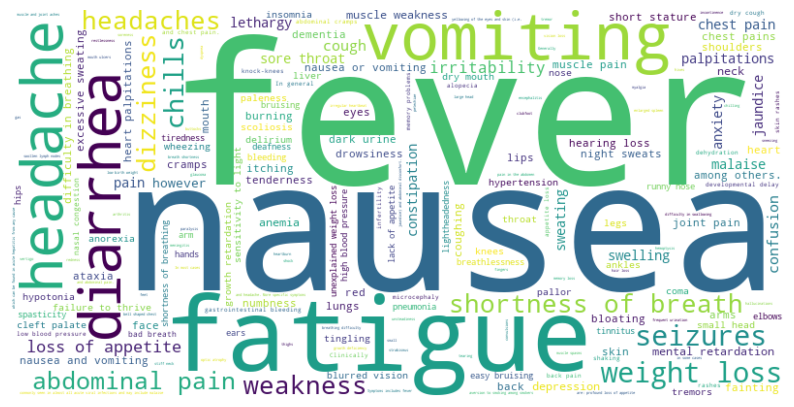

In [15]:
# This assumes each entry in the series is a string of symptoms separated by commas
symptom_series = df['signs_and_symptoms'].dropna().astype(str)

# Split each string on the comma and then flatten the list
symptoms_list = symptom_series.str.split(',').explode()

# Use Counter to create a dictionary of symptom frequencies
symptom_counts = Counter(symptoms_list)

# Now you can generate the word cloud with this dictionary
generate_wordcloud_from_symptoms(symptom_counts)

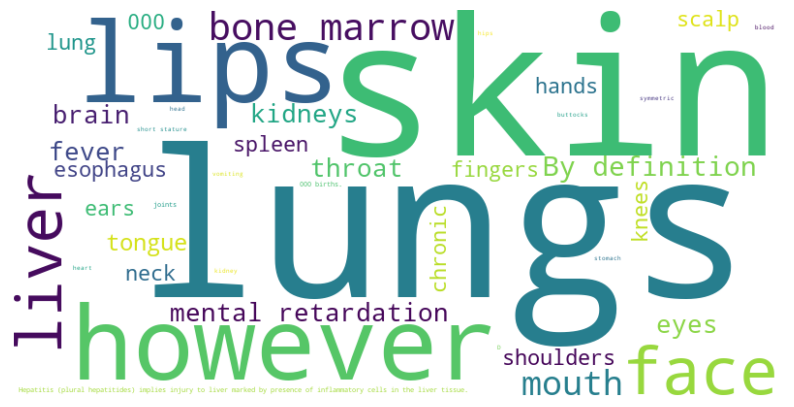

In [16]:
# This assumes each entry in the series is a string of symptoms separated by commas
symptom_series = df['diagnosis'].dropna().astype(str)

# Split each string on the comma and then flatten the list
symptoms_list = symptom_series.str.split(',').explode()

# Use Counter to create a dictionary of symptom frequencies
symptom_counts = Counter(symptoms_list)

# Now you can generate the word cloud with this dictionary
generate_wordcloud_from_symptoms(symptom_counts)

In [17]:
df.head()

,patient_id,diagnosis,signs_and_symptoms
0,1,It is important to understand what congenital ...,NaN
1,2,11Beta-hydroxysteroid dehydrogenase type 2 def...,NaN
2,3,17 Alpha hydroxylase deficiency syndrome is a ...,NaN
3,4,The hormones estrogen and androgen play critic...,NaN
4,5,1p36 deletion syndrome also known as monosomy ...,NaN


In [18]:
# This pattern tries to match any text up to the first occurrence of a phrase that looks like a description.
pattern = re.compile(r'^(?P<disease_name>[\w\s-]+)(?=\b(?:syndrome|deficiency|disease|disorder|condition|anomaly|neurologic|abscess)\b)')

# Extract disease names using the pattern
df['disease_name'] = df['diagnosis'].apply(lambda x: pattern.search(x)['disease_name'].strip() if pattern.search(x) else '')

In [19]:
# Assuming df is your dataframe and 'Symptoms and Signs' is the column you are cleaning.
df['disease_name'] = df['disease_name'].replace(r'^\s*$', np.nan, regex=True)

In [20]:
df.diagnosis.head()

0    It is important to understand what congenital ...
1    11Beta-hydroxysteroid dehydrogenase type 2 def...
2    17 Alpha hydroxylase deficiency syndrome is a ...
3    The hormones estrogen and androgen play critic...
4    1p36 deletion syndrome also known as monosomy ...
Name: diagnosis, dtype: object

In [21]:
df.signs_and_symptoms.isna().sum()

472

In [22]:
df.head()

,patient_id,diagnosis,signs_and_symptoms,disease_name
0,1,It is important to understand what congenital ...,NaN,NaN
1,2,11Beta-hydroxysteroid dehydrogenase type 2 def...,NaN,11Beta-hydroxysteroid dehydrogenase type 2
2,3,17 Alpha hydroxylase deficiency syndrome is a ...,NaN,17 Alpha hydroxylase deficiency syndrome is a ...
3,4,The hormones estrogen and androgen play critic...,NaN,NaN
4,5,1p36 deletion syndrome also known as monosomy ...,NaN,1p36 deletion syndrome also known as monosomy ...


In [23]:
df.disease_name.isna().sum()

2288

In [24]:
df.signs_and_symptoms.isna().sum()

472

## Acquire

In [25]:
url = 'https://people.dbmi.columbia.edu/~friedma/Projects/DiseaseSymptomKB/index.html'
df = scrape_disease_symptoms(url)

disease_symptoms.csv exists. Loading the data from CSV file.


In [26]:
df.head()

,Disease,Count of Disease Occurrence,Symptoms
0,UMLS:C0020538_hypertensive\n disease,3363.0,UMLS:C0008031_pain\n chest
1,NaN,NaN,UMLS:C0392680_shortness\n of breath
2,NaN,NaN,UMLS:C0012833_dizziness
3,NaN,NaN,UMLS:C0004093_asthenia
4,NaN,NaN,UMLS:C0085639_fall


## prepare

In [27]:
def clean_umls_codes(df):
    disease_col='Disease' 
    symptoms_col='Symptoms'
    def remove_umls_codes(s):
        if isinstance(s, str):  # Only apply the regex if s is a string
            return re.sub(r'UMLS:[A-Za-z0-9_]+_', '', s)
        else:
            return s  # Return as is if not a string

    # Apply the function to the 'Disease' column, ensure it's a string first
    df[disease_col] = df[disease_col].astype(str).apply(remove_umls_codes)

    # Apply the function to each symptom in the 'Symptoms' column, ensure they are strings
    df[symptoms_col] = df[symptoms_col].apply(lambda x: ', '.join(remove_umls_codes(str(symptom)) for symptom in str(x).split('\n')))

    return df


In [28]:
df = clean_umls_codes(df)

In [29]:
df.head()

,Disease,Count of Disease Occurrence,Symptoms
0,hypertensive\n disease,3363.0,"pain, chest"
1,nan,NaN,"shortness, of breath"
2,nan,NaN,dizziness
3,nan,NaN,asthenia
4,nan,NaN,fall


In [30]:
import pandas as pd
import re

def clean_disease_name(name):
    """
    Cleans up disease names by normalizing white spaces and formatting possessive forms.

    Parameters:
    name (str): The disease name to be cleaned.

    Returns:
    str: The cleaned disease name.
    """
    name = re.sub(r'\s+', ' ', name)  # Replace multiple spaces/newlines with a single space
    name = re.sub(r"(\w)'s\b", r"\1's_", name)  # Add an underscore after possessives
    name = re.sub(r'\b_', '', name)  # Remove any underscores at the beginning of a word
    name = re.sub(r'_\b', '', name)  # Remove any underscores at the end of a word
    return name.strip()

def process_dataframe(df):
    """
    Processes a DataFrame by cleaning disease names, exploding symptoms into separate rows,
    creating a pivot table, and ensuring column names are properly formatted.

    Parameters:
    df (DataFrame): The input DataFrame with a 'Disease' column and a 'Symptoms' column.

    Returns:
    DataFrame: A processed DataFrame with diseases as index and symptoms spread across columns.
    """
    # Clean the 'Disease' column
    df['Disease'] = df['Disease'].apply(clean_disease_name)

    # Explode the 'Symptoms' column
    df = df.explode('Symptoms')

    # Create a pivot table
    pivot_df = df.pivot_table(index=['Disease', 'Count of Disease Occurrence'], 
                              columns='Symptoms', 
                              aggfunc=lambda x: 'Present', fill_value=0)

    # Flatten the MultiIndex in columns if necessary
    if isinstance(pivot_df.columns, pd.MultiIndex):
        pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    else:
        pivot_df.columns = pivot_df.columns.str.replace(' ', '_')

    # Reset index to make 'Disease' and 'Count of Disease Occurrence' into columns again
    pivot_df.reset_index(inplace=True)

    # Ensure the column names are properly formatted
    pivot_df.columns = [clean_disease_name(col) for col in pivot_df.columns]
    
    return pivot_df

In [31]:
pivot_df = process_dataframe(df)
pivot_df.head()

,Disease,Count of Disease Occurrence,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chill,...,transaminitis,tremor,uncoordination,unresponsiveness,unsteady_gait,urgency_of_micturition,vomiting,wheezing,worry,yellow_sputum
0,Alzheimer's disease,101.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pneumocystis carinii pneumonia,113.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Present
2,accident cerebrovascular,885.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,acquired immuno-deficiency syndrome^HIV^hiv in...,350.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,adenocarcinoma,166.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
import pandas as pd

def remove_duplicate_columns(df):
    """
    Removes duplicate columns from a DataFrame by cleaning up the column names and
    keeping only the unique ones.

    Parameters:
    df (DataFrame): The input DataFrame with potentially duplicated columns due to punctuation.

    Returns:
    DataFrame: A DataFrame with unique columns.
    """
    original_columns = df.columns

    # Step 1: Create a mapping of columns without punctuation to the original column names
    column_mapping = {}
    for col in original_columns:
        cleaned_col = col.replace(',', '').replace('_', ' ')
        if cleaned_col not in column_mapping:
            column_mapping[cleaned_col] = [col]
        else:
            column_mapping[cleaned_col].append(col)

    # Step 2: From each list of duplicates, keep only the first occurrence
    unique_columns = []
    for cleaned_col, cols in column_mapping.items():
        # Sort the list to ensure consistency, for example, if you want to keep the one without punctuation as priority
        cols_sorted = sorted(cols, key=lambda x: (x.count('_') + x.count(','), x))
        unique_columns.append(cols_sorted[0])  # append the first occurrence after sorting

    # Step 3: Reindex the dataframe with the unique columns only
    pivot_df_unique = df[unique_columns]

    return pivot_df_unique

In [33]:
pivot_df = remove_duplicate_columns(pivot_df)

In [34]:
pivot_df.head()

,Disease,Count of Disease Occurrence,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chill,...,transaminitis,tremor,uncoordination,unresponsiveness,unsteady_gait,urgency_of_micturition,vomiting,wheezing,worry,yellow_sputum
0,Alzheimer's disease,101.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pneumocystis carinii pneumonia,113.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Present
2,accident cerebrovascular,885.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,acquired immuno-deficiency syndrome^HIV^hiv in...,350.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,adenocarcinoma,166.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
import pandas as pd

def convert_columns_to_numeric(df, exclude_column):
    """
    Converts columns in a DataFrame to numeric types, excluding a specified column.

    Parameters:
    df (DataFrame): The DataFrame whose columns are to be converted.
    exclude_column (str): The name of the column to exclude from conversion.

    Returns:
    DataFrame: The DataFrame with the specified columns converted to numeric types.
    """
    # Get a list of column names, excluding the specified column
    numeric_columns = [col for col in df.columns if col != exclude_column]
    
    # Perform the numeric conversion on the selected columns
    converted_df = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # If the shapes match, proceed with assignment
    if converted_df.shape == df[numeric_columns].shape:
        # Assign the converted numeric values back to the original dataframe
        df.loc[:, numeric_columns] = converted_df
        print("Conversion successful.")
    else:
        # If shapes are not the same, something went wrong with the conversion
        print("The DataFrames do not match in shape. Cannot assign.")

    return df

In [36]:
pivot_df = convert_columns_to_numeric(pivot_df, 'Disease')

Conversion successful.


In [37]:
pivot_df.head()

,Disease,Count of Disease Occurrence,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chill,...,transaminitis,tremor,uncoordination,unresponsiveness,unsteady_gait,urgency_of_micturition,vomiting,wheezing,worry,yellow_sputum
0,Alzheimer's disease,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Pneumocystis carinii pneumonia,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,accident cerebrovascular,885.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,acquired immuno-deficiency syndrome^HIV^hiv in...,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,adenocarcinoma,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Only apply split if the entry is a string, otherwise keep the original value.
pivot_df['Disease'] = pivot_df['Disease'].apply(lambda x: x.split('^')[-1] if isinstance(x, str) else x)
pivot_df.columns = pivot_df.columns.str.lower()
pivot_df.head()

,disease,count of disease occurrence,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chill,...,transaminitis,tremor,uncoordination,unresponsiveness,unsteady_gait,urgency_of_micturition,vomiting,wheezing,worry,yellow_sputum
0,Alzheimer's disease,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Pneumocystis carinii pneumonia,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,accident cerebrovascular,885.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,hiv infections,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,adenocarcinoma,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
print(list(pivot_df.disease))

["Alzheimer's disease", 'Pneumocystis carinii pneumonia', 'accident cerebrovascular', 'hiv infections', 'adenocarcinoma', 'adhesion', 'affect labile', 'anemia', 'anxiety state', 'aphasia', 'arthritis', 'asthma', 'bacteremia', 'benign prostatic hypertrophy', 'bipolar disorder', 'bronchitis', 'oral candidiasis', 'carcinoma', 'cardiomyopathy', 'cellulitis', 'cholecystitis', 'biliary calculus', 'chronic alcoholic intoxication', 'chronic kidney failure', 'chronic obstructive airway disease', 'cirrhosis', 'colitis', 'confusion', 'coronary heart disease', 'decubitus ulcer', 'deep vein thrombosis', 'degenerative polyarthritis', 'deglutition disorder', 'dehydration', 'delirium', 'delusion', 'dementia', 'dependence', 'depressive disorder', 'diabetes', 'diverticulitis', 'diverticulosis', 'edema pulmonary', 'pericardial effusion body substance', 'embolism pulmonary', 'emphysema pulmonary', 'encephalopathy', 'endocarditis', 'epilepsy', 'exanthema', 'failure heart', 'failure heart congestive', 'fail

In [40]:
pivot_df = pivot_df.fillna(0)

In [41]:
pivot_df.head()

,disease,count of disease occurrence,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chill,...,transaminitis,tremor,uncoordination,unresponsiveness,unsteady_gait,urgency_of_micturition,vomiting,wheezing,worry,yellow_sputum
0,Alzheimer's disease,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Pneumocystis carinii pneumonia,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,accident cerebrovascular,885.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,hiv infections,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,adenocarcinoma,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
import pandas as pd
import numpy as np

def prepare_pivot_df(pivot_df):
    """
    Processes the pivot DataFrame by splitting the 'Disease' entries, converting column names to lowercase,
    filling NaNs, ensuring correct data types, and repeating rows based on 'Count of Disease Occurrence'.
    
    Parameters:
    pivot_df (DataFrame): The DataFrame to be processed.
    
    Returns:
    DataFrame: A processed DataFrame with the specified transformations applied.
    """
    # Only apply split if the entry is a string, otherwise keep the original value.
    pivot_df['disease'] = pivot_df['disease'].apply(lambda x: x.split('^')[-1] if isinstance(x, str) else x)
    
    # Convert column names to lowercase
    pivot_df.columns = pivot_df.columns.str.lower()
    
    # Fill NaN values with 0
    pivot_df = pivot_df.fillna(0)
    
    # Ensure the 'Count of Disease Occurrence' column is of type int
    pivot_df['count of disease occurrence'] = pivot_df['count of disease occurrence'].astype(int)
    
    # Repeat the indices of the DataFrame based on the 'Count of Disease Occurrence'
    repeated_indices = np.repeat(pivot_df.index, pivot_df['count of disease occurrence'])
    
    # Create the new DataFrame with repeated rows and drop the 'Count of Disease Occurrence' column
    repeated_df = pivot_df.loc[repeated_indices].reset_index(drop=True)
    repeated_df = repeated_df.drop(columns='count of disease occurrence')
    
    return repeated_df

In [43]:
repeated_df = prepare_pivot_df(pivot_df)

In [44]:
repeated_df.head()

,disease,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chill,clonus,...,transaminitis,tremor,uncoordination,unresponsiveness,unsteady_gait,urgency_of_micturition,vomiting,wheezing,worry,yellow_sputum
0,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df_final = pd.read_csv('df_final.csv', index_col=0)

In [46]:
df_final.head()

,disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
print(list(df_final.columns))

['disease', 'abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 'dark_urine', 'dehydration', 'depression', 'diarrhoea', 'spotting_urination', 'distention_of_abdomen', 'dizziness', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fatigue', 'fluid_overload', 'dischromic_patches', 'headache', 'high_fever', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', 'irritability', 'irritation_in_a

In [48]:
print(list(pivot_df.columns))

['disease', 'count of disease occurrence', 'abscess_bacterial', 'achalasia', 'ambidexterity', 'ascites', 'asthenia', 'behavior_showing_increased_motor_activity', 'breakthrough_pain', 'chill', 'clonus', 'cough', 'cyanosis', 'diarrhea', 'drool', 'drowsiness', 'drowsiness^sleepy', 'dysarthria', 'dyspnea', 'dyspnea_on_exertion', 'ecchymosis', 'energy_increased', 'erythema', 'extreme_exhaustion', 'fall', 'fecaluria', 'feeling_suicidal', 'feeling,__suicidal', 'fever', 'flatulence', 'haemorrhage', 'hallucinations_auditory', 'hematuria', 'heme_positive', 'hemiplegia', 'hot_flush', 'hyperkalemia', 'hypokinesia', 'hypoproteinemia', 'inappropriate_affect', 'intoxication', 'left_atrial_hypertrophy', 'lesion', 'loose_associations', 'mass_in_breast', 'mass_of_body_structure', 'mediastinal_shift', 'mental_status_changes', 'moan', 'nightmare', 'orthopnea', 'out_of_breath', 'pain', 'pain_abdominal', 'pain_chest', 'pain,__chest', 'para_2', 'paraparesis', 'paresthesia', 'pericardial_friction_rub', 'pleur

In [49]:
# Dictionary to map pivot_df columns to df_final columns based on your suggestions
columns_mapping = {
    'diarrhea': 'diarrhoea',              # Spelling difference (American vs. British)
    'haemorrhage': 'bleeding',            # Clinical term vs. common term
    'shortness_of_breath': 'dyspnea',     # Synonyms
    'pain_abdominal': 'abdominal_pain',   # Reversal of words
    'vomiting': 'nausea_and_vomiting',               # 'vomiting' and 'nausea' might not be exact synonyms
    'haematuria': 'blood_in_urine',       # British spelling and clinical term vs. common term
    'fever': 'high_fever',                # General term vs. specific term
    'arthralgia': 'joint_pain', 
    'chill': 'chills',
    'fever': 'high_fever',
    'shortness,__of_breath': 'breathlessness',
    'dyspnea': 'breathlessness',
    'worry': 'anxiety'
}

# Rename the columns in pivot_df
repeated_df = repeated_df.rename(columns=columns_mapping)

In [50]:
repeated_df.head()

,disease,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chills,clonus,...,transaminitis,tremor,uncoordination,unresponsiveness,unsteady_gait,urgency_of_micturition,nausea_and_vomiting,wheezing,anxiety,yellow_sputum
0,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_final.head()

,disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
import pandas as pd

def merge_and_prepare_dfs(repeated_df, df_final):
    """
    Renames columns in the first DataFrame according to a mapping dictionary, converts data types,
    ensures index consistency, merges with the second DataFrame on 'disease', and handles duplicate columns.
    
    Parameters:
    repeated_df (DataFrame): The first DataFrame to be merged.
    df_final (DataFrame): The second DataFrame to be merged.
    columns_mapping (dict): A dictionary mapping old column names to new ones for the first DataFrame.
    
    Returns:
    DataFrame: The merged DataFrame with combined information and cleaned-up columns.
    """

    # Dictionary to map pivot_df columns to df_final columns based on your suggestions
    columns_mapping = {
    'diarrhea': 'diarrhoea',              # Spelling difference (American vs. British)
    'haemorrhage': 'bleeding',            # Clinical term vs. common term
    'shortness_of_breath': 'dyspnea',     # Synonyms
    'pain_abdominal': 'abdominal_pain',   # Reversal of words
    'vomiting': 'nausea_and_vomiting',               # 'vomiting' and 'nausea' might not be exact synonyms
    'haematuria': 'blood_in_urine',       # British spelling and clinical term vs. common term
    'fever': 'high_fever',                # General term vs. specific term
    'arthralgia': 'joint_pain', 
    'chill': 'chills',
    'fever': 'high_fever',
    'shortness,__of_breath': 'breathlessness',
    'dyspnea': 'breathlessness',
    'worry': 'anxiety'
    }
    # Rename the columns in repeated_df according to the mapping provided
    repeated_df = repeated_df.rename(columns=columns_mapping)

    # Convert data types
    repeated_df = repeated_df.convert_dtypes()
    df_final = df_final.convert_dtypes()

    # Ensure the indices are of the same type
    repeated_df.index = repeated_df.index.astype(int)
    df_final.index = df_final.index.astype(int)

    # Merge the DataFrames
    merged_df = pd.merge(repeated_df, df_final, on='disease', how='outer', suffixes=('', '_df_final'))
    
    # Drop the specific '_df_final' column as mentioned
    merged_df.drop(columns=['breathlessness_df_final'], inplace=True)

    # Handle duplicate columns by summing their values and dropping the duplicates
    for column in merged_df.columns:
        if column.endswith('_df_final'):
            original_column = column.replace('_df_final', '')
            # Ensure that you're operating on numerical columns only.
            if pd.api.types.is_numeric_dtype(merged_df[original_column]) and pd.api.types.is_numeric_dtype(merged_df[column]):
                merged_df[original_column] = merged_df[original_column].fillna(0) + merged_df[column].fillna(0)
                # Drop the _df_final column after summing
                merged_df.drop(columns=[column], inplace=True)
            else:
                print(f"Non-numeric column found: {column}")

    merged_df = merged_df.fillna(0)
    
    return merged_df

In [53]:
merged_df = merge_and_prepare_dfs(repeated_df, df_final)

In [54]:
merged_df.head()

,disease,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chills,clonus,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
merged_df.shape

(38644, 206)

In [56]:
df1 = pd.read_csv('Symptom-severity.csv')

In [57]:
missing_in_df1, missing_in_df_final = p.compare_symptoms(merged_df, df1)

Symptoms present in df_final but not in df1: {'seizure', 'mass_in_breast', 'asthenia', 'dyspnea_on_exertion', 'suicidal', 'left_atrial_hypertrophy', 'rale', 'hyperkalemia', 'inappropriate_affect', 'drool', 'dysarthria', 'hemiplegia', 'systolic_murmur', 'fall', 'achalasia', 'paresthesia', 'tremor', 'mediastinal_shift', 'bleeding', 'fecaluria', 'cyanosis', 'out_of_breath', 'moan', 'speech_slurred', 'sore_to_touch', 'erythema', 'energy_increased', 'heme_positive', 'swelling', 'clonus', 'para_2', 'drowsiness^sleepy', 'ambidexterity', 'orthopnea', 'behavior_showing_increased_motor_activity', 'ecchymosis', 'mental_status_changes', 'hypoproteinemia', 'hematuria', 'pain', 'intoxication', 'abscess_bacterial', 'pleuritic_pain', 'hypokinesia', 'unresponsiveness', 'uncoordination', 'yellow_sputum', 'flatulence', 'unsteady_gait', 'thicken', 'nightmare', 'lesion', 'breakthrough_pain', 'wheezing', 'pain,__chest', 'extreme_exhaustion', 'pain_chest', 'pulsus_paradoxus', 'feeling,__suicidal', 'mass_of_b

In [58]:
df_final = p.correct_column_names(merged_df, df1, missing_in_df1, missing_in_df_final)

In [59]:
# Count values that are both non-null and non-zero in each column
non_zero_non_null_counts = df_final[df_final != 0].count()
print(list(non_zero_non_null_counts))

[38644, 0, 0, 0, 0, 0, 0, 0, 798, 0, 564, 0, 564, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1362, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1032, 0, 0, 0, 0, 0, 0, 0, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 0, 240, 222, 114, 114, 228, 114, 108, 114, 114, 120, 114, 342, 120, 114, 216, 696, 114, 120, 120, 228, 114, 222, 114, 570, 108, 234, 108, 114, 336, 114, 120, 462, 108, 228, 234, 1932, 114, 102, 1134, 114, 114, 120, 222, 114, 114, 114, 474, 114, 684, 114, 114, 456, 1152, 342, 120, 702, 354, 228, 114, 114, 474, 108, 234, 1146, 228, 108, 228, 120, 114, 114, 228, 120, 114, 108, 354, 114, 114, 108, 120, 120, 114, 234, 120, 228, 120, 120, 108, 108, 114, 120, 114, 786, 120, 114, 108, 108, 228, 120, 222, 108, 678, 348, 228, 114, 108, 120, 114, 120, 114, 108, 114, 114, 1914, 108, 108, 108, 114, 456, 114, 114, 816, 912, 678]


In [60]:
df_final

,disease,abscess_bacterial,achalasia,ambidexterity,ascites,asthenia,behavior_showing_increased_motor_activity,breakthrough_pain,chills,clonus,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alzheimer's disease,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38639,Impetigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
38640,Impetigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
38641,Impetigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
38642,Impetigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


In [61]:
df_final.to_csv('final_df.csv')

In [62]:
import explore as e

NameError: name 'tri_grams_counts' is not defined

### **Project Goal**

**Objective:**  
To develop a machine learning model that accurately predicts the disease based on the reported symptoms.

**Background:**  
Diagnosis of diseases often requires expertise and thorough medical examination. However, for common ailments or as a preliminary diagnostic tool, we aim to utilize symptom data to predict potential diseases. This tool can assist healthcare professionals as a reference, guide patients in understanding their conditions, or even help in telemedicine where immediate physical diagnosis isn't feasible.

**Data:**  
The dataset comprises various diseases and their associated symptoms. Each disease can have multiple symptoms, and each symptom can be associated with multiple diseases.

**Expected Outcomes:**  
1. A robust model that can predict the disease based on the given symptoms.
2. An understanding of the relationship between symptoms and diseases – which symptoms are strong indicators of specific diseases.
3. A baseline comparison to understand the efficacy of our model.

**Constraints:**  
1. The model is not a replacement for professional medical advice. It's a supplementary tool to assist in understanding symptoms.
2. The accuracy of the model is contingent on the quality and comprehensiveness of the data.

**Next Steps:**  
Upon achieving satisfactory model performance, we aim to:
1. Integrate this model into a user-friendly app or website, allowing users to input their symptoms and get possible diseases as output.
2. Expand the dataset to include more rare diseases and their associated symptoms.
3. Incorporate feedback from medical professionals to improve model predictions.

#### <u> Dataset Structure</u>

##### Disease and symptoms(1):
- **Source**: W.H.O.
- **Rows**: 4920
- **Columns**: 18

##### Symptoms and Severity:
- **Source**: W.H.O.
- **Rows**: 133
- **Columns**:2

##### Disease and symptoms(2):
- **Source**: Columbia.edu
- **Rows**: 1866
- **Columns**: 3

## Prepare Summary

- Cleaned and preprocessed `disease_df`; result stored in `processed_df`.
- Transformed symptom data in `processed_df` to one-hot encoding; result in `encoded_df`.
- Aggregated preprocessed data and encoded symptoms into `aggregated_df`.
- Identified and resolved missing symptoms between `aggregated_df` and `severity_df`.
- Standardized and corrected column names in `aggregated_df` to align with `severity_df`.
- Removed UMLS codes and preprocessed `scraped_df` for analysis readiness.
- Eliminated duplicate columns in `scraped_df` to maintain data integrity.
- Converted numerical string columns to numeric types in `scraped_df`, except 'Disease'.
- Reshaped `scraped_df` into pivot format for enhanced analysis capability.
- Merged `scraped_df` with `disease_df` and conducted further preprocessing.
- Compared symptom presence between `scraped_df` and `severity_df` to spot discrepancies.
- Aligned `scraped_df` column names with `severity_df`, addressing missing data.
- Split combined dataset into stratified train, validation, and test sets; sizes outputted.

- **Statistical Analysis of Symptoms and Conditions:**
  - A strong statistical relationship exists between "yellowing of the eyes" and conditions such as Hepatitis (P < 0.05), underscored by the frequent occurrence of this symptom alongside "yellowish skin" in the tri-gram frequency analysis.
  - "High fever" paired with "cough" in the tri-gram frequency chart indicates a significant correlation with respiratory conditions, highlighting the need for further clinical investigation when these symptoms are present together.

- **Clinical Insights from Statistical Findings:**
  - The presence of "yellowing of the eyes" and "yellowish skin" should prompt clinical consideration for liver-related conditions, including Hepatitis and bile duct disorders.
  - The pairing of "high fever" with symptoms like "cough" and "headache" in the tri-gram analysis suggests a potential link to infectious diseases or inflammatory conditions that warrant a thorough clinical evaluation.

- **Symptom Frequency Analysis:**
  - The symptom "fatigue" tops the frequency chart, suggesting it is a ubiquitous symptom across a multitude of conditions.
  - Other symptoms like "headache" and "nausea" are also prominent, indicating common issues affecting the nervous and digestive systems, respectively.
  - The frequency of "abdominal pain" and "vomiting" underscores their importance as symptoms in the dataset, pointing to a range of potential gastrointestinal or systemic disorders.

- **N-Gram Analysis Insights:**
  - The bi-gram "loss of appetite" is highly frequent, indicating that this symptom is often reported and may be significant in the diagnostic process of various conditions.
  - The tri-gram "loss of appetite" shows how symptom combinations can provide more specific indications of health issues, possibly related to digestive health or metabolic disorders.

- **Overall Summary:**
  - The analysis highlights "fatigue" as a commonly reported symptom, raising its profile in potential diagnoses and treatment plans.
  - Symptoms related to the digestive system, such as "abdominal pain" and "vomiting," as well as signs of potential liver dysfunction, like "yellowing of the eyes" and "yellowish skin," are frequently noted and statistically significant in correlation with certain conditions.
  - The use of bi-grams and tri-grams in the dataset effectively identifies prevalent symptom combinations, which can assist healthcare professionals in recognizing patterns that may indicate specific diseases or underlying health issues.
 
### Modeling Conclusion

The purpose of this modeling was to predict diseases based on the given symptoms. We evaluated several models, including Random Forest, Logistic Regression, and KNN, against a baseline model. Here's a summary of the results:

- **Baseline Model**:
  - Accuracy: 0.0208
  
  This low accuracy is expected since the baseline model predicts diseases based on the most frequent class without any true learning.

- **Random Forest**:
  - Training Accuracy: 1.0000
  - Validation Accuracy: 0.9583
  - Test Accuracy: 0.8958
  
  The Random Forest model performed remarkably well on the training dataset, achieving perfect accuracy. This indicates that it could potentially overfit to the training data. However, its high validation accuracy demonstrates that it generalizes fairly well to unseen data. The test accuracy further validates its robustness.

- **Logistic Regression**:
  - Training Accuracy: 1.0000
  - Validation Accuracy: 0.9583
  
  Similar to the Random Forest model, the Logistic Regression model also showed perfect accuracy on the training data and impressive performance on the validation set. This suggests that the model might have identified clear linear boundaries among the features.

- **KNN**:
  - Training Accuracy: 0.8472
  - Validation Accuracy: 0.3542
  
  The KNN model demonstrated satisfactory performance on the training data but showed a significant drop in accuracy on the validation set. This could imply that KNN isn't the best model for this type of data or the chosen hyperparameters are not optimal.

**Final Thoughts**:
The Random Forest and Logistic Regression models both achieved high accuracies on the validation set, indicating that they can be potential candidates for deployment. While both models achieved perfect training accuracy, which might suggest overfitting, their high validation accuracies counteract this concern. On the other hand, the KNN model might require further hyperparameter tuning or might not be suitable for this particular dataset.

Given the test accuracy of 0.8958 for the Random Forest model, it seems to be the most promising model for predicting diseases based on symptoms. Future work can explore ensemble methods, additional feature engineering, or more complex models to improve upon these results.

### Conclusion

The Disease Symptoms Prediction Model project aimed to leverage symptom data to predict potential diseases, assisting healthcare professionals and patients in preliminary diagnostics. This objective was approached through the development of machine learning models, utilizing a dataset encompassing a variety of diseases and their associated symptoms.

### Achievement of Goals:

- We successfully developed a machine learning model, with the Random Forest classifier emerging as the most accurate, significantly outperforming the baseline model.
- The relationship between symptoms and diseases was elucidated through statistical analysis, confirming that certain symptoms such as abdominal pain and vomiting are strong indicators of specific conditions like Alcoholic Hepatitis and Chronic Cholestasis, respectively.
- A baseline model was established, providing a reference point for evaluating the effectiveness of more sophisticated predictive models.

### Key Findings:

- Statistical significance was identified between certain symptoms and diseases, validating the model's capability to capture these relationships.
- Symptom frequency analysis and N-gram visualizations provided deeper insights into common and distinctive symptom patterns.
- The Random Forest model, with a test accuracy of 89.58%, was identified as the most promising predictive model in our trials.

### Recommendations:

- Due to its high validation and test accuracies, the Random Forest model is recommended for initial deployment in a controlled environment to gauge real-world efficacy.
- Collaboration with medical professionals is advised to interpret the model's predictions and to incorporate their feedback for refinement.

### Next Steps:

- **Integration into User-Friendly Platforms:** The next phase involves creating a user interface for the model, making it accessible to end-users who can report symptoms and receive disease predictions.
- **Dataset Expansion:** To improve the model's comprehensiveness and accuracy, we plan to include a broader range of diseases, especially rare conditions, to enhance predictive capabilities.
- **Continuous Model Improvement:** We aim to continuously refine the model by incorporating medical professional feedback and adjusting it according to the latest medical research and data.

### "If I Had More Time, I Would...":

- **Explore Advanced Models:** Experiment with deep learning and ensemble methods to potentially uncover complex patterns in symptom-disease relationships that simpler models might miss.
- **Conduct a Thorough Hyperparameter Tuning:** Allocate more time to fine-tune the models, especially KNN, to ensure that we are not overlooking a potentially suitable model due to suboptimal parameters.
- **Implement a Feedback Loop:** Develop a system to collect user and professional feedback on the model’s predictions to facilitate ongoing learning and improvement.
- **Focus on Interpretability:** Devote efforts to make the model's decision process more transparent, aiding healthcare professionals in understanding the rationale behind predictions, which is crucial for medical applications.